# CNN Modelling

Imports and Configs

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os, pathlib
from contextlib import ExitStack

# Configs
sns.set_theme()
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

**Note: According to multiple sources, there's a bug with numpy and tensorflow resulting in an 'ImplementError' from some function calls. Downgrading to the versions below should fix the problem**

In [2]:
print(f'Numpy version: {np.version.version}')
print(f'Tensorflow version: {tf.__version__}')

Numpy version: 1.20.3
Tensorflow version: 2.5.0


# Preprocessing

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

display(df_train.head())
display(df_test.head())

,File Names,Labels
0,000_0001.png,0
1,000_0002.png,0
2,000_0003.png,0
3,000_0004.png,0
4,000_0005.png,0


,File Names,Labels
0,000_0001_j.png,0
1,000_0002_j.png,0
2,000_0003_j.png,0
3,000_0004_j.png,0
4,000_0005_j.png,0


In [4]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170 entries, 0 to 4169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File Names  4170 non-null   object
 1   Labels      4170 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File Names  1994 non-null   object
 1   Labels      1994 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.3+ KB


None

Dropping missing classes

In [5]:
unique_classes_test = df_test['Labels'].unique()
unique_classes_train= df_train['Labels'].unique()
missing_classes_train = [x for x in unique_classes_test if x not in unique_classes_train]
missing_classes_test = [x for x in unique_classes_train if x not in unique_classes_test]
missing_classes = np.concatenate([missing_classes_test, missing_classes_train])

print(f'Test missing classes relative to Train Set: {missing_classes_test}')
print(f'Train missing classes relative to Test Set: {missing_classes_train}')

Test missing classes relative to Train Set: [9, 18, 19, 33]
Train missing classes relative to Test Set: []


In [6]:
to_drop_train = df_train[df_train['Labels'].isin(missing_classes)].index
to_drop_test = df_test[df_test['Labels'].isin(missing_classes)].index
df_train.drop(index=to_drop_train, inplace=True)
df_test.drop(index=to_drop_test, inplace=True)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## Three Datasets

To better understand how the model performs with imbalanced data, three datasets will be made. 

    Dataset 1: No undersampled classes removed
    Dataset 2: Classes with less than 50 samples removed
    Dataset 3 : Classes with less than 100 samples removed

Of course, instead of creating three different datasets, which would be very memory inefficient, 3 indexes will be made to reference the same large dataset.

In [7]:
filter_50 = df_train['Labels'].value_counts() <= 50
filter_100 = df_train['Labels'].value_counts() <= 100

under_50 = df_train['Labels'].value_counts()[filter_50].index # This is a list of classes
under_100 = df_train['Labels'].value_counts()[filter_100].index

# These are lists of indices
idx_50_train = df_train[~df_train['Labels'].isin(under_50)].index
idx_50_test = df_test[~df_test['Labels'].isin(under_50)].index
idx_100_train = df_train[~df_train['Labels'].isin(under_100)].index
idx_100_test = df_test[~df_test['Labels'].isin(under_100)].index

min_class_50 = df_train.loc[idx_50_train]['Labels'].value_counts().min()
min_class_100 = df_train.loc[idx_100_train]['Labels'].value_counts().min()
print(f'Under 50 dataset minimum class count: {min_class_50}')
print(f'Under 100 dataset minimum class count: {min_class_100}')

Under 50 dataset minimum class count: 56
Under 100 dataset minimum class count: 110


## Homogenizing Image Sizes

CNNs can't accept images with different sizes. CNNs are fitted on a flattened image (1D Array) of a certain size, meaning it can't be fitted on other images of different sizes. The images in this dataset all have different sizes. Considering this, the images will be resized to close to the average height and width with padding to not distort the image.

The dataframes before were simply filenames and labels. The actual images haven't been loaded yet. This can be done by loading them in as PIL instances and converting them to arrays using tensorflow's img_to_array function.

In [8]:
train_dir = 'data/tsrd-train'
test_dir = 'data/tsrd-test'

# Using the dataframe makes it possible to easily load only the desired images instead of loading
# the entire directory and filtering again.
train_fnames = [os.path.join(train_dir, fname) for fname in df_train['File Names']]
test_fnames = [os.path.join(test_dir, fname) for fname in df_test['File Names']]

# Loading image files using a context manager
with ExitStack() as stack:
    train_imgs = [stack.enter_context(Image.open(fname)) for fname in train_fnames]
    test_imgs = [stack.enter_context(Image.open(fname)) for fname in test_fnames]

    # Converting images to array format using tensorflow's image processing utils
    train_imgs = [image.img_to_array(img) for img in train_imgs]
    test_imgs = [image.img_to_array(img) for img in test_imgs]

In [9]:
heights, widths = [img.shape[1] for img in train_imgs], [img.shape[0] for img in train_imgs]
width_mean, height_mean = sum(widths)/len(widths), sum(heights)/len(heights)
print(f'Average width: {width_mean}, Average height: {height_mean}')

Average width: 140.85500963391138, Average height: 152.1878612716763


In [10]:
train_imgs = convert_to_tensor([resize_with_pad(img, 150, 150) for img in train_imgs])
test_imgs = convert_to_tensor([resize_with_pad(img, 150, 150) for img in test_imgs])
print(train_imgs.shape, test_imgs.shape)

(4152, 150, 150, 3) (1994, 150, 150, 3)


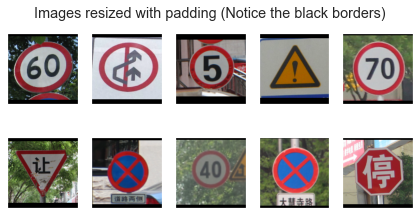

In [11]:
random_idx = np.random.randint(low=0, high=len(train_imgs), size=10)

fig, ax = plt.subplots(2, 5)
ax = np.ravel(ax)

for idx, img_idx in enumerate(random_idx):
    ax[idx].imshow(image.array_to_img(train_imgs[img_idx]))
    ax[idx].set(
        xticks=[],
        yticks=[]
    )
fig.suptitle('Images resized with padding (Notice the black borders)', y=0.85)
fig.tight_layout()

## Merging image data and labels

In [12]:
# Full Dataset
train_labels = pd.get_dummies(df_train['Labels'])
test_labels = pd.get_dummies(df_test['Labels'])

# Under 50
train_labels_50 = pd.get_dummies(df_train.loc[idx_50_train]['Labels'])
test_labels_50 = pd.get_dummies(df_test.loc[idx_50_test]['Labels'])

# Under 100
train_labels_100 = pd.get_dummies(df_train.loc[idx_100_train]['Labels'])
test_labels_100 = pd.get_dummies(df_test.loc[idx_100_test]['Labels'])

if not (train_labels.columns == test_labels.columns).all():
    raise Exception('Train and Test one-hot encoded labels are not indexed the same.')

print(f'Index of one-hot encoded labels: \n {train_labels.columns}')

Index of one-hot encoded labels: 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
            20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37,
            38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
            55, 56, 57],
           dtype='int64')


In [13]:
datagen = ImageDataGenerator()

# Full Data
train_iterator = datagen.flow(train_imgs, train_labels, batch_size=128, seed=42)
test_iterator = datagen.flow(test_imgs, test_labels, batch_size=128, shuffle=False)

# Without Classes under 50
train_iterator_50 = datagen.flow(
    tf.gather(train_imgs, indices=idx_50_train), 
    train_labels_50,
     batch_size=128, seed=42
    )
test_iterator_50 = datagen.flow(
    tf.gather(test_imgs, indices=idx_50_test), 
    test_labels_50,
    batch_size=128, shuffle=False
    )

# Without Classes under 100
train_iterator_100 = datagen.flow(
    tf.gather(train_imgs, indices=idx_100_train), 
    train_labels_100,
     batch_size=128, seed=42
    )
test_iterator_100 = datagen.flow(
    tf.gather(test_imgs, indices=idx_100_test), 
    test_labels_100,
    batch_size=128, shuffle=False
    )

## The Model

The model will consist of various convolutional layers coupled with max-pooling layers. The convolutional layers allow the network to learn the various features of an image while the max-pooling layer reduces noise and helps with overfitting. The number of neurons can be arbitrarily choesn. Other arguments use the defaults.


Finally, the model was structured based on two sources: the source above and another one below:

    https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

## Data Standardization
CNN's work better with constrained values, so the image's RGB values will be limited to a [0,1] range.

        Source:
        https://www.tensorflow.org/tutorials/images/classification

Fortunately, with tensorflow's api, this can be done within the model itself.

In [14]:
standardize = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
def create_model(num_classes):
    model = Sequential([
        layers.InputLayer(input_shape=(150, 150, 3)),
        standardize,
        layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'),
        layers.MaxPool2D(strides=2),
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPool2D(strides=2),
        layers.Conv2D(128, (9, 9), activation='relu'),
        layers.MaxPool2D(strides=2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam', loss='categorical_crossentropy', metrics='categorical_accuracy'
    )

    return model

model = create_model(len(train_labels.columns))
model_50 = create_model(len(train_labels_50.columns))
model_100 = create_model(len(train_labels_100.columns))
print(
    model.summary(),
    model_50.summary(),
    model_100.summary()
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       663680    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0

### Base Accuracy

In [16]:
base_accuracy = df_train['Labels'].value_counts(normalize=True).iloc[0]
base_accuracy

0.10741811175337188

### Defining class weights

As demonstrated in the class distribution graph, the dataset is imbalanced and hence class weights have to be assigned. Class weights can be manually assigned but, for this project, the following formula will be used:

    weight = n_samples / (n_classes * n_samples_class)

    n_samples = total length of dataset
    n_classes = number of unique classes
    n_samples_class = total samples of that class

    Source: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

As the labels are sorted in ascending order as shown previously, the weights can be similarly indexed.

In [17]:
def create_weights(df):
    weight = lambda n_samples, n_classes, n_samples_class:\
        n_samples/(n_classes*n_samples_class)

    counts = df['Labels'].value_counts().sort_index(ascending=True)

    n_samples, n_classes = len(df), len(counts)
    weights = []
    for count in counts:
        n_samples_class = count
        weights.append(weight(n_samples, n_classes, n_samples_class))

    weights = dict(zip(list(range(n_classes)), weights))

    return weights

weights = create_weights(df_train)
weights_50 = create_weights(df_train.loc[idx_50_train])
weights_100 = create_weights(df_train.loc[idx_100_train])


In [18]:
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
early_stopping = EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_categorical_accuracy'
)

In [19]:
history = model.fit(
    train_iterator,
    validation_data = test_iterator,
    epochs=100,
    class_weight=weights,
    callbacks=[early_stopping],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100


InternalError:  Blas xGEMM launch failed : a.shape=[1,128,21632], b.shape=[1,21632,512], m=128, n=512, k=21632
	 [[node sequential/dense/MatMul (defined at <ipython-input-19-456deb797a91>:1) ]] [Op:__inference_train_function_376351]

Function call stack:
train_function


In [ ]:
history_50 = model_50.fit(
    train_iterator_50,
    validation_data = test_iterator_50,
    epochs=100,
    class_weight=weights_50,
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 [==============================] - 6s 213ms/step - loss: 2.9151 - categorical_accuracy: 0.1450 - val_loss: 2.5208 - val_categorical_accuracy: 0.2415
Epoch 2/100
27/27 [==============================] - 3s 121ms/step - loss: 1.8475 - categorical_accuracy: 0.4638 - val_loss: 3.0787 - val_categorical_accuracy: 0.3541
Epoch 3/100
27/27 [==============================] - 3s 121ms/step - loss: 0.9795 - categorical_accuracy: 0.6983 - val_loss: 1.8260 - val_categorical_accuracy: 0.5550
Epoch 4/100
27/27 [==============================] - 3s 121ms/step - loss: 0.4071 - categorical_accuracy: 0.8645 - val_loss: 1.5466 - val_categorical_accuracy: 0.6445
Epoch 5/100
27/27 [==============================] - 3s 119ms/step - loss: 0.1691 - categorical_accuracy: 0.9493 - val_loss: 2.0172 - val_categorical_accuracy: 0.6459
Epoch 6/100
27/27 [==============================] - 3s 122ms/step - loss: 0.0603 - categorical_accuracy: 0.9783 - val_loss: 2.0272 - val_categorical_accuracy: 0.677

In [ ]:
history_100 = model_100.fit(
    train_iterator_100,
    validation_data = test_iterator_100,
    epochs=100,
    class_weight=weights_100,
    callbacks=[early_stopping]
)

Epoch 1/100
22/22 [==============================] - 4s 179ms/step - loss: 2.4735 - categorical_accuracy: 0.2083 - val_loss: 1.7957 - val_categorical_accuracy: 0.4072
Epoch 2/100
22/22 [==============================] - 2s 105ms/step - loss: 1.1575 - categorical_accuracy: 0.6064 - val_loss: 1.2082 - val_categorical_accuracy: 0.5720
Epoch 3/100
22/22 [==============================] - 2s 106ms/step - loss: 0.5079 - categorical_accuracy: 0.8220 - val_loss: 1.2397 - val_categorical_accuracy: 0.6553
Epoch 4/100
22/22 [==============================] - 2s 105ms/step - loss: 0.2147 - categorical_accuracy: 0.9174 - val_loss: 1.2200 - val_categorical_accuracy: 0.7197
Epoch 5/100
22/22 [==============================] - 2s 105ms/step - loss: 0.1447 - categorical_accuracy: 0.9379 - val_loss: 1.3445 - val_categorical_accuracy: 0.6989
Epoch 6/100
22/22 [==============================] - 2s 105ms/step - loss: 0.0648 - categorical_accuracy: 0.9766 - val_loss: 1.4837 - val_categorical_accuracy: 0.712

In [ ]:
_, acc = model.evaluate(test_iterator)
_, acc_50 = model_50.evaluate(test_iterator_50)
_, acc_100 = model_100.evaluate(test_iterator_100)

9/9 [==============================] - 0s 25ms/step - loss: 1.3826 - categorical_accuracy: 0.7803


In [ ]:
predictions = model.predict(test_iterator)
predictions_50 = model_50.predict(test_iterator_50)
predictions_100 = model_100.predict(test_iterator_100)

# Metrics

## Accuracy

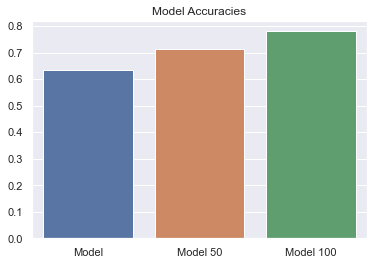

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.barplot(y = [acc, acc_50, acc_100], x=['Model', 'Model 50', 'Model 100'], ax=ax).set_title(
    'Model Accuracies'
    );

fig.savefig('visualizations/model_accuracies.png')

## Confusion Matrix

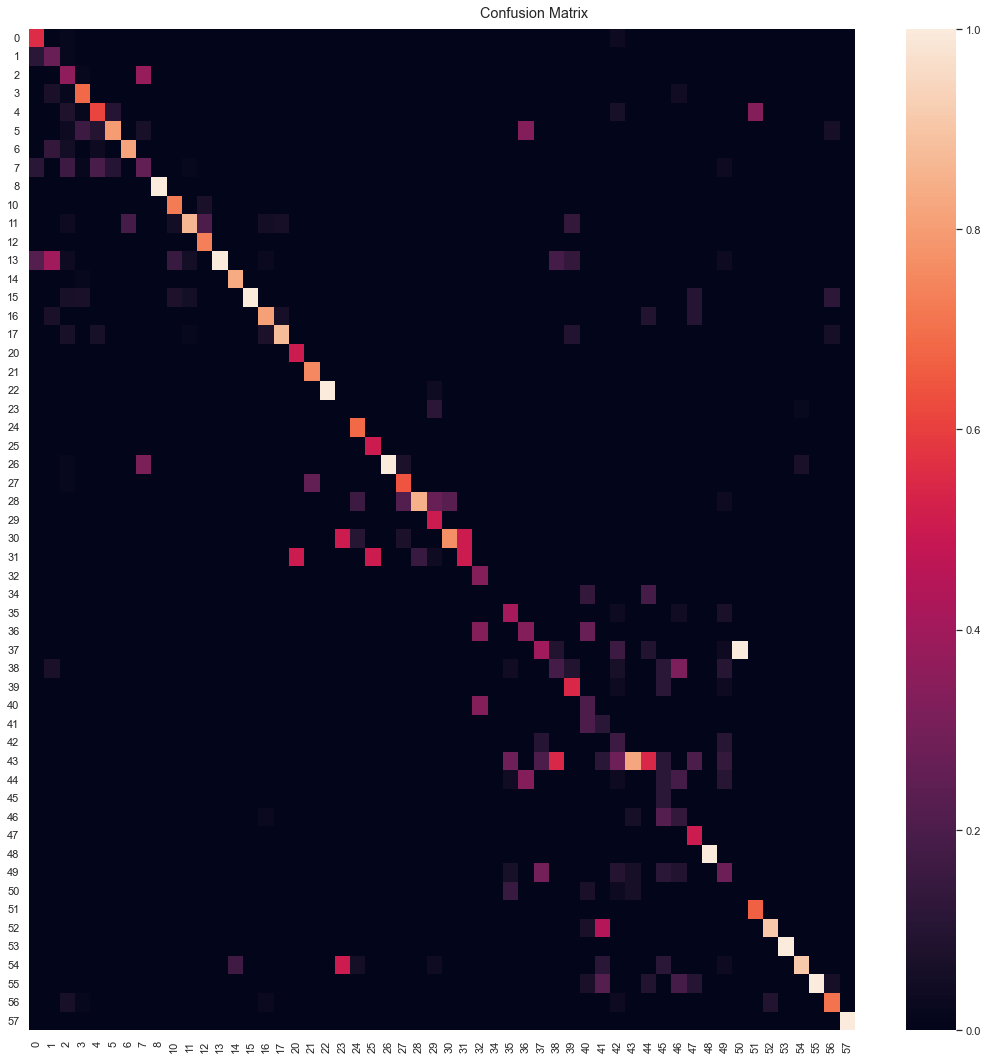

In [ ]:
matrix = confusion_matrix(
    y_true=[np.argmax(value) for value in test_labels.values],
    y_pred=[np.argmax(prediction) for prediction in predictions],
    normalize='pred'
    )

fig, ax = plt.subplots(1, 1)
sns.heatmap(
    matrix, ax=ax,
    xticklabels=test_labels.columns, yticklabels=test_labels.columns
    )

fig.set(
    figwidth=15, figheight=15
)

fig.suptitle('Confusion Matrix')
fig.tight_layout()
fig.savefig('visualizations/heatmap.png')

## Confusion Matrix Sorted

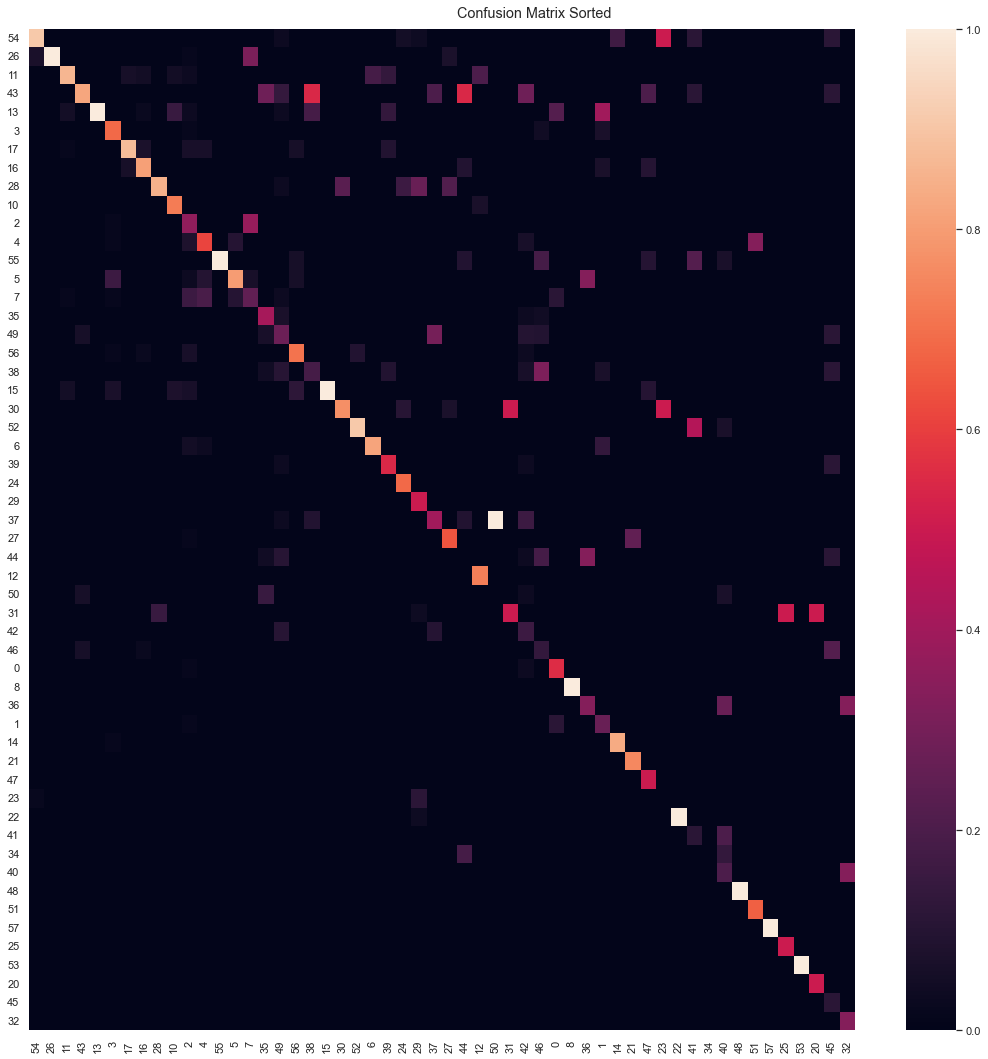

In [ ]:
sorted_classes = df_test['Labels'].value_counts().index
predictions_df = pd.DataFrame(predictions, columns=test_labels.columns).loc[:, sorted_classes]
sorted_labels = test_labels.loc[:, sorted_classes]

sorted_matrix = confusion_matrix(
    y_true=[np.argmax(value) for value in sorted_labels.values],
    y_pred=[np.argmax(prediction) for prediction in predictions_df.values],
    normalize='pred'
    )

fig, ax = plt.subplots(1, 1)
sns.heatmap(
    sorted_matrix, ax=ax,
    xticklabels=predictions_df.columns, yticklabels=predictions_df.columns
    )

fig.set(
    figheight=15, figwidth=15
)

fig.suptitle('Confusion Matrix Sorted')
fig.tight_layout()
fig.savefig('visualizations/heatmap_sorted.png')

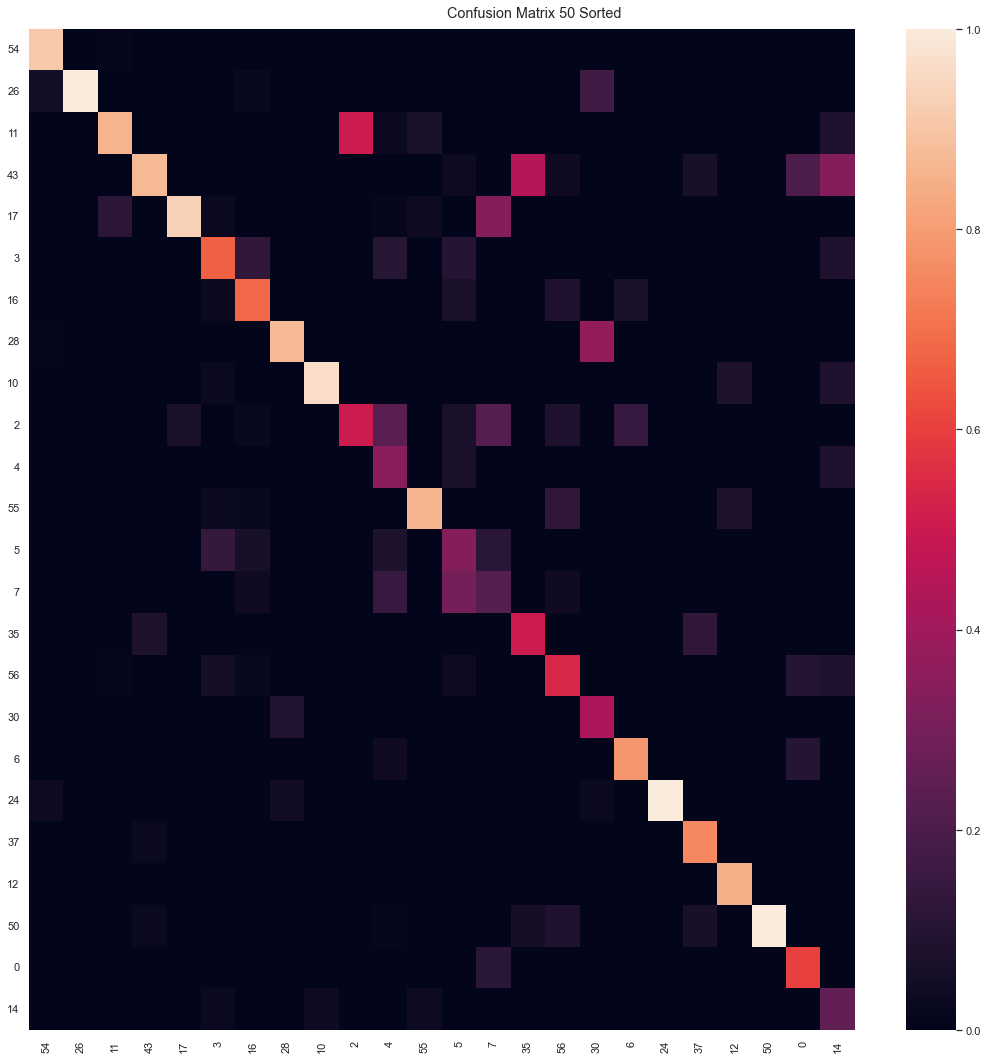

In [ ]:
sorted_classes = df_test.loc[idx_50_test]['Labels'].value_counts().index
predictions_df = pd.DataFrame(predictions_50, columns=test_labels_50.columns).loc[:, sorted_classes]
sorted_labels = test_labels_50.loc[:, sorted_classes]

sorted_matrix = confusion_matrix(
    y_true=[np.argmax(value) for value in sorted_labels.values],
    y_pred=[np.argmax(prediction) for prediction in predictions_df.values],
    normalize='pred'
    )

fig, ax = plt.subplots(1, 1)
sns.heatmap(
    sorted_matrix, ax=ax,
    xticklabels=predictions_df.columns, yticklabels=predictions_df.columns
    )

fig.set(
    figheight=15, figwidth=15
)

fig.suptitle('Confusion Matrix 50 Sorted')
fig.tight_layout()
fig.savefig('visualizations/heatmap_sorted_50.png')

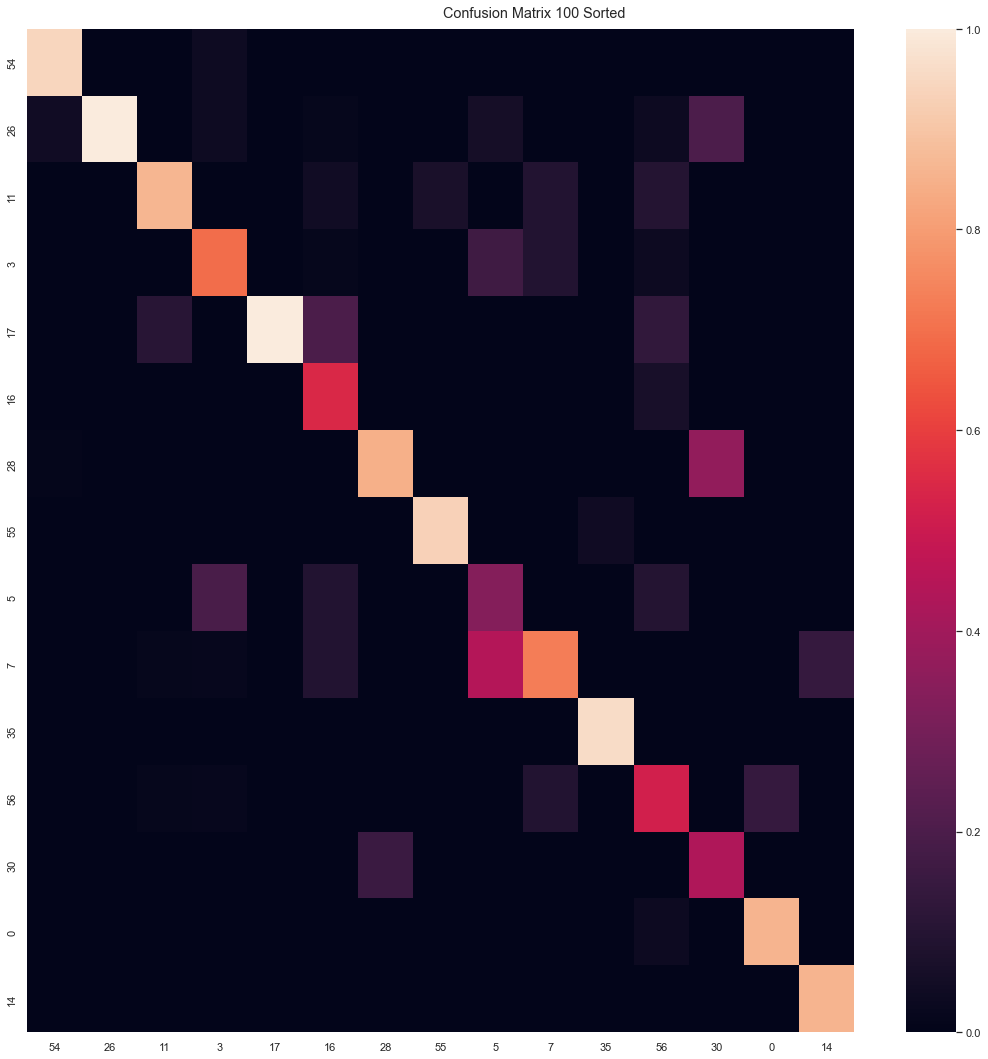

In [ ]:
sorted_classes = df_test.loc[idx_100_test]['Labels'].value_counts().index
predictions_df = pd.DataFrame(predictions_100, columns=test_labels_100.columns).loc[:, sorted_classes]
sorted_labels = test_labels_100.loc[:, sorted_classes]

sorted_matrix = confusion_matrix(
    y_true=[np.argmax(value) for value in sorted_labels.values],
    y_pred=[np.argmax(prediction) for prediction in predictions_df.values],
    normalize='pred'
    )

fig, ax = plt.subplots(1, 1)
sns.heatmap(
    sorted_matrix, ax=ax,
    xticklabels=predictions_df.columns, yticklabels=predictions_df.columns
    )

fig.set(
    figheight=15, figwidth=15
)

fig.suptitle('Confusion Matrix 100 Sorted')
fig.tight_layout()
fig.savefig('visualizations/heatmap_sorted_100.png')